In [1]:
col_names = [
    'dv-fv',
    'dv', 
    'fv'
]

In [4]:
import configparser
import warnings
import pandas as pd
from pymongo import MongoClient
import json
import requests
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# config = configparser.ConfigParser()
# config.read('config.ini')
# host = config['DEFAULT']['IP']
# port = config['DEFAULT']['MongoDB-Port']
# user = config['DEFAULT']['User']
# pw = config['DEFAULT']['Pw']

# client = MongoClient(host, int(port), username=user, password=pw)
# db = client['mediacloud']

# Copy to Local

In [174]:
df = pd.DataFrame()
for col in col_names:
    df = pd.concat([df, pd.DataFrame(list(db[col].find()))])
df.shape

(12845, 17)

In [175]:
df_test = df.copy()
titles = []
texts = []

for _,row in df_test.iterrows():
    title = row['title'].replace('&#8217;', "'").replace('&#8216;',"'").replace('&#8230;','...').replace('&#8211;','-').replace('&#124;','|').replace('&#39;',"'").replace('&#038;','&').replace('&#8220;','"').replace('&#8221;','"')
    text = row['text'].replace('&#x2019;', "'").replace('&#275;','e')
    titles.append(title)
    texts.append(text)
    
df_test['title'] = titles
df_test['text'] = texts

In [181]:
df = df_test.copy()
df.to_csv('database/media_cloud_database.csv')

# Read Local DB

In [ ]:
df = pd.read_csv('output/media_cloud_database.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

# Topic Modelling

In [1]:
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer 

from pandas import ExcelWriter

In [2]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    return ''.join([c for c in s if c.isalpha()])

In [3]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real',
    'good',
    'get',
    'go',
    'have',
    'do',
    'take',
    'time','year','month','week','day','say',
    'per','cent','percent','people',
    'mr','ms','miss','mrs'
])

### Main

### Parameters

In [130]:
year = 2017
start = 4
limit = 14
step = 1
n = 40 #how many articles to extract for each topic

In [131]:
### Read from original database
df_current = df[df['publish_date'].str.contains(str(year))]
#df_current.reset_index(inplace=True)




### Read from cleaned (relavent) database
df_current = pd.read_csv('output/remove_irrelavent/{}/{}_relavent.csv'.format(year, year))





df_current = df_current.replace(np.nan, '', regex=True)
print(len(df_current))

2146


In [132]:
data = []

for i, row in df_current.iterrows():
    data.append(row['text'])
        
    if i % 100 == 0:
        print(i, end = ' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 

### Pre-processing

In [11]:
def clean_doc(doc):
    cleaned_doc = ''
    for token in doc.split():

        # Cleaning
        if token[0] in ['@','$','%','^','&','*','#'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())

        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_doc += lemma + ' '

    return cleaned_doc.strip()

In [133]:
data_lemmatized = []
data_filtered = []
dups = set()
indices = [] # points back to index in df_current data

check = []

for i, doc in enumerate(data):
    
    
    
    #### For the 1st round, keep the duplicates
#     cleaned_doc = clean_doc(doc)    
#     data_lemmatized.append(cleaned_doc.split())
#     data_filtered.append(cleaned_doc)
    
    
    
    
    
    
    #### After we remove irrelavent docs, we also need to remove duplicates
    
    doc = doc.replace('.', '|').replace('?','|').replace('!','|')
    
    # Use 1st sentence to check duplicates
    first_sent = doc.split('|')[0]
    cleaned_1_sent = clean_doc(first_sent)
    
    if len(cleaned_1_sent) > 0 and cleaned_1_sent not in dups:
        dups.add(cleaned_1_sent)

        cleaned_doc = clean_doc(doc)
        
        data_lemmatized.append(cleaned_doc.split())
        data_filtered.append(cleaned_doc)
        indices.append(i)
    else:
        if len(cleaned_1_sent) > 0:
            check.append(first_sent)
        
    if i % 100 == 0:
        print(i, end=' ')
        
len(data_lemmatized)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 

1688

### Removal record for duplicates

In [134]:
with open('output/final_output/{}/{}_remove_record.txt'.format(year, year), 'a') as f:
    f.write('\nNo. of duplicated docs removed: {}\n'.format(len(df_current)-len(data_lemmatized)))
    f.write('\nNo. of docs remaining: {}\n'.format(len(data_lemmatized)))

# Model

In [135]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
mallet_path = 'input/mallet-2.0.8/bin/mallet'

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [136]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

0-4 1-5 2-6 3-7 4-8 5-9 6-10 7-11 8-12 9-13 

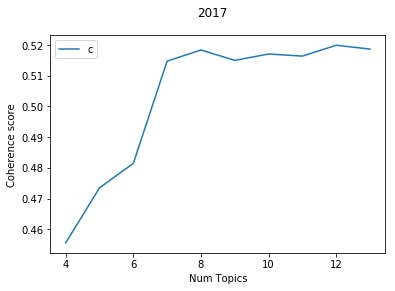

In [137]:
x = range(start, limit, step)
plt.figure().suptitle(str(year))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
#plt.savefig('output/topic_models/{}_pre_relavent.png'.format(year))
plt.savefig('output/topic_models/{}.png'.format(year))
plt.show()

### Save models

In [138]:
for i in range(start, limit):
    model_list[i-start].save('output/topic_models/{}_{}'.format(year, i))
    #model_list[i-start].save('output/topic_models/{}_{}_pre_relavent'.format(year, i))

## Select model

In [151]:
no_topics = 10
model = model_list[no_topics-start]

In [659]:
#### Only for loading saved models
# no_topics = 8
# model = gensim.models.wrappers.LdaMallet.load('output/topic_models/{}_{}'.format(year, no_topics))

In [152]:
### displaying

pyLDAvis.enable_notebook()
the_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
vis = pyLDAvis.gensim.prepare(the_model, corpus, id2word)
pyLDAvis.save_html(vis, 'output/final_output/{}/{}_{}.html'.format(year, year, no_topics))
#vis

# Docs

In [122]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [153]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3227,"police, crime, officer, report, assault, offence, nsw, incident, local, area",lust revenge greed pride envy wrath motif murder read like seven deadly sin rarely change start ...
1,1,4.0,0.2742,"police, crime, officer, report, assault, offence, nsw, incident, local, area",victim receive compensation act government drop significantly last despite rise victim seek help...
2,2,1.0,0.3912,"court, man, police, charge, woman, hear, yearold, bail, murder, sentence",yearold man charge murder allege dispute umina beach central coast ben ivanoff accuse stab wife ...
3,3,5.0,0.1566,"woman, men, female, white, support, experience, gender, work, dr, male",copyright aest gmt play nicely current browser please moment upgrade latest version
4,4,3.0,0.4702,"child, abuse, life, mother, live, parent, relationship, happen, young, father",room second floor childrens hospital westmead team specialise staff weigh collective consciousne...


In [154]:
# Group top n Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(n)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Show
sent_topics_sorteddf_mallet.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1315,0.0,0.7156,"story, world, work, start, write, book, life, watch, film, yard",iphone x weird wonderful device apple new phone look behave differently iphones use two become f...
1,1171,0.0,0.6962,"story, world, work, start, write, book, life, watch, film, yard",emma alberici join former lateline host kerry obrien maxine mckew leigh sale reflect latelines v...
2,1267,0.0,0.6917,"story, world, work, start, write, book, life, watch, film, yard",maze runner trilogy jam dashner dystopian young adult novel paint bleak picture humanity thomas ...
3,270,0.0,0.6262,"story, world, work, start, write, book, life, watch, film, yard",jimmy barnes barely set foot inside melbourne landmark pellegrinis end bourke street voice pip b...
4,484,0.0,0.6234,"story, world, work, start, write, book, life, watch, film, yard",author liane moriarty like fair chunk tvviewing planet recently little lie utterly grip business...


# Excel

In [155]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic_Num,,,
1,"court, man, police, charge, woman, hear, yearold, bail, murder, sentence",313,18.54%
8,"community, service, support, school, program, house, provide, health, fund, work",224,13.27%
6,"government, million, minister, state, labor, queensland, pay, leader, party, federal",196,11.61%
9,"law, victim, report, act, sexual, system, court, change, order, university",173,10.25%
4,"police, crime, officer, report, assault, offence, nsw, incident, local, area",161,9.54%
3,"child, abuse, life, mother, live, parent, relationship, happen, young, father",143,8.47%
7,"play, club, game, player, win, team, sport, star, season, award",136,8.06%
5,"woman, men, female, white, support, experience, gender, work, dr, male",129,7.64%
2,"alcohol, house, street, melbourne, car, home, city, council, homeless, sydney",114,6.75%


In [156]:
writer = ExcelWriter('output/final_output/{}/{}_{}.xlsx'.format(year, year, no_topics))
#writer = ExcelWriter('output/final_output/{}/{}_pre_relevant_{}.xlsx'.format(year, year, no_topics))

new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(no_topics):
    new_df = pd.DataFrame(columns=['Document_No'])
    new_df['Document_No'] = sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet['Dominant_Topic']==topic_no]['Document_No']

    
    
    
    #### For after removing duplicates
    new_df['Document_No'] = list(map(lambda x: indices[x], new_df['Document_No']))
    
    
    
    
    new_df.set_index('Document_No', inplace=True)
    
    new_df['Title'] = list(map(lambda x: df_current.iloc[x]['title'], new_df.index))
    new_df['Text'] = list(map(lambda x: df_current.iloc[x]['text'], new_df.index))
    new_df['URL'] = list(map(lambda x: df_current.iloc[x]['url'], new_df.index))
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()

# Remove irrelavent coduments

In [128]:
topic_nos = [9,2]

In [129]:
ids_to_rm = []

with open('output/final_output/{}/{}_remove_record.txt'.format(year, year), 'w') as f:
    for topic_to_rm in topic_nos:
        df_to_rm = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_to_rm-1]
        rm_list = list(df_to_rm['Document_No'])
        ids_to_rm.extend(rm_list)
        f.write('No. of docs removed for topic {}: {}\n'.format(topic_to_rm, len(rm_list)))
        f.write('Topic {} keywords: '.format(topic_to_rm))
        f.write(df_to_rm.iloc[0]['Keywords'])
        f.write('\n\n')
        
df_rm = df_current[df_current.index.isin(ids_to_rm)]
df_keep = df_current[~df_current.index.isin(ids_to_rm)]
df_rm.set_index('_id', inplace=True)
df_keep.set_index('_id', inplace=True)
df_rm.drop(['index'], axis=1, inplace=True)
df_keep.drop(['index'], axis=1, inplace=True)

print(len(df_rm), len(df_keep))
df_rm.to_csv('output/remove_irrelavent/{}/{}_irrelavent.csv'.format(year, year))
df_keep.to_csv('output/remove_irrelavent/{}/{}_relavent.csv'.format(year, year))

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


306 2146
